# Defining The Accelerator
Using a GPU if available, else a CPU. In this case, satisfactory performance is obtained with a CPU and training time is not too high.

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-in-csv/mnist_train.csv
/kaggle/input/mnist-in-csv/mnist_test.csv


In [3]:
#Loading the training data
train = pd.read_csv('../input/mnist-in-csv/mnist_train.csv')

# Defining the Training Data
From the original MNIST dataset, 60000 images are chosen for training. The training data is reshaped into 28x28 numpy array to represent the grayscale images. Finally, an important step of normalization follows to allow the GAN to converge better. 

In [4]:
train_data = train.drop(labels = ['label'], axis = 1)
train_data = train_data.values.reshape(-1, 28, 28)
train_data = train_data/255.0

#To create some space
del train 

In [5]:
#Just checking if the data type is as expected
print(isinstance(train_data, np.ndarray))

#Checking the sanity of the shape of the training data
print(train_data.shape)

True
(60000, 28, 28)


# Visualizing the Data
Randomly plotting one of the training examples to catch a drift about the training data.

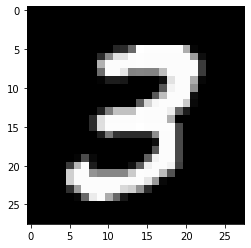

In [6]:
plt.imshow(train_data[7], cmap = 'gray')

# Using DataLoader
To allow for efficient iteration over the different mini-batches using a hard coded batch size of 32.

In [7]:
#Converting to torch tensor
train_data = torch.Tensor(train_data)

#Checking to confirm dtype as tensor
print(isinstance(train_data, torch.Tensor))

random_seed = 1
batch_size = 32
train_dl = DataLoader(train_data, batch_size, shuffle = True)

True


# Noise Generation
The input to the generator in a GAN is usually random noise. Here, I use torch.rand to generate random numbers between 0 and 1 and then rescale the numbers to fall between -1 and 1 so as to make the mean 0 for the uniform distribution to facilitate the training of the GAN.

In [8]:
def random_noise_generator(batch_size, dim):
    return torch.rand(batch_size, dim)*2 - 1

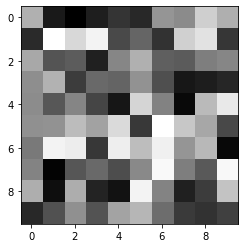

In [9]:
#Just checking the noise generator and plotting one of its outputs
a = random_noise_generator(64, 100)
b = a[2]
b = b.reshape(10, 10)
b = b.numpy()
plt.imshow(b, cmap = 'gray')

# Discriminator Model
The discriminator model is fairly straightforward having a few fully connected layers having one small caveat, instead of the usual ReLU for activation, here, I've used a **leaky ReLU**. This is because, a leaky ReLU has a small gradient for negative values of input, allowing for a stronger flow of gradients from the discriminator to the generator. Also, some dropout layers have been added in intermediate stages to prevent overfitting. 
Further, the final output is supposed to be between 0 and 1 (to predict if real or fake), however, the loss function used later on is **BCEWithLogitsLoss** (for numerical stability) which combines the sigmoid with the normal binary cross entropy function, so, no activation function is applied to the output.

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size*4)
        self.fc2 = nn.Linear(hidden_size*4, hidden_size*2)
        self.fc3 = nn.Linear(hidden_size*2, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        out = self.fc4(x)
        return out

# Generator Model
The generator model is quite similar to the discriminator, with two small differences:
1. Instead of the input being downscaled, it's upscaled to reach expected dimensions of MNIST dataset images.
2. Final activation function **tanh** is applied to the output bringing its values between -1 and 1 for best performance.

In [11]:
class Generator(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size*2)
        self.fc3 = nn.Linear(hidden_size*2, hidden_size*4)
        self.fc4 = nn.Linear(hidden_size*4, output_size)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        out = torch.tanh(self.fc4(x))
        return out

# Setting Model Hyperparameters
Input size to the generator is hard coded to be 100. Can be manipulated to check variations in performance.

In [12]:
#For Discriminator
input_disc = 784
hidden_disc = 32
output_disc = 1

#For Generator
input_gen = 100
hidden_gen = 32
output_gen = 784

In [13]:
#Creating instances of models
D = Discriminator(input_disc, hidden_disc, output_disc)
G = Generator(input_gen, hidden_gen, output_gen)

#Sanity check of the model instances
print(D)
print(G)

#Passing to the GPU
D = D.to(device)
G = G.to(device)

D = D.float()
G = G.float()

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


# Discriminator Loss
Discriminator loss is the resultant sum of two components:
1. On passing real training set images through the discriminator, the output values are compared with 1 (for real images) and real loss is calculated.
2. On passing random noise through the generator, fake images are created which are further passed through the discriminator. These outputs are compared with 0 (for fake images) and fake loss is calculated.

I have defined relevant functions to calculate real loss, fake loss and the resultant sum of these two losses.

In [14]:
Loss = nn.BCEWithLogitsLoss()
def discriminator_real_loss(real_out):
    real_label = torch.ones(real_out.size()[0], 1).to(device)
    real_loss = Loss(real_out.squeeze(), real_label.squeeze())
    return real_loss

def discriminator_fake_loss(fake_out):
    fake_label = torch.zeros(fake_out.size()[0], 1).to(device)
    fake_loss = Loss(fake_out.squeeze(), fake_label.squeeze())
    return fake_loss

def discriminator_loss(real_out, fake_out):
    real_loss = discriminator_real_loss(real_out)
    fake_loss = discriminator_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)
    return total_loss

# Generator Loss
Passing random noise through the generator, we get fake images. On further passing these through the discriminator, we get their output labels. Since we want the generator to fool the discriminator, these output labels are compared with 1 (for supposedly real images) and loss is calculated.

In [15]:
def generator_loss(gen_disc_out):
    label = torch.ones(gen_disc_out.size()[0], 1).to(device)
    gen_loss = Loss(gen_disc_out.squeeze(), label.squeeze())
    return gen_loss

# Defining Optimizers
Using Adam optimizers for both discriminator and generator. The learning rate is adjusted to 0.002, a slight deviation from the original paper, to allow for faster learning in this case.

In [16]:
disc_opt = optim.Adam(D.parameters(), lr = 0.002)
gen_opt = optim.Adam(G.parameters(), lr = 0.002)

# Training the GAN
The GAN was trained with a mini-batch size of 32 for 25 epochs and samples of the generator output were printed every 5 epochs to monitor the progress of the generator.

In [17]:
def train(D, G, disc_opt, gen_opt, train_dl, batch_size = 32, epochs = 25, gen_input_size = 100):
    
    disc_losses = []
    gen_losses = []
    
    #Having a fixed sample to monitor the progress of the generator
    sample_size = 16
    fixed_samples = random_noise_generator(sample_size, gen_input_size)
    fixed_samples = fixed_samples.to(device)
    
    #Going into training mode
    D.train()
    G.train()
    
    for epoch in range(epochs + 1):
        
        disc_loss_total = 0
        gen_loss_total = 0
        gen_out = 0
        
        for train_x in train_dl:
            
            #Discriminator training
            disc_opt.zero_grad()
            
            train_x = train_x*2 - 1          #Converting the real images to have values between -1 and 1
            train_x = train_x.to(device)     #Passing to GPU
            real_out = D(train_x.float())    
            
            disc_gen_in = random_noise_generator(batch_size, gen_input_size)
            disc_gen_in = disc_gen_in.to(device)   #Passing to GPU
            
            disc_gen_out = G(disc_gen_in.float()).detach()  #Detaching to avoid training the generator
            fake_out = D(disc_gen_out.float())
            
            disc_loss = discriminator_loss(real_out, fake_out)  #Loss calculation
            disc_loss_total += disc_loss
            disc_loss.backward()
            disc_opt.step()  
        
            #Generator training
            gen_opt.zero_grad()
            
            gen_out = G(disc_gen_in.float())     #Feeding noise into the generator
            gen_disc_out = D(gen_out.float())       #Passing into the discrminator
            
            gen_loss = generator_loss(gen_disc_out)  #Generator loss calculation
            gen_loss_total += gen_loss
            gen_loss.backward()
            gen_opt.step()
        
        disc_losses.append(disc_loss_total)
        gen_losses.append(gen_loss_total)
        
        #Plotting samples every 5 epochs
        if epoch%5 == 0:
            G.eval()                    #Going into eval mode to get sample images         
            samples = G(fixed_samples.float())
            G.train()                   #Going back into train mode
            
            fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
            for ax, img in zip(axes.flatten(), samples):
               img = img.cpu().detach()
               ax.xaxis.set_visible(False)
               ax.yaxis.set_visible(False)
               im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        
        
        #Printing losses every epoch
        print("Epoch ", epoch, ": Discriminator Loss = ", disc_loss_total/len(train_dl), ", Generator Loss = ", gen_loss_total/len(train_dl))    
    
    return disc_losses, gen_losses

Epoch  0 : Discriminator Loss =  tensor(1.1523, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.4839, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  1 : Discriminator Loss =  tensor(1.1262, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.2806, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  2 : Discriminator Loss =  tensor(1.1249, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.1822, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  3 : Discriminator Loss =  tensor(1.1927, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.0564, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  4 : Discriminator Loss =  tensor(1.2154, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.9927, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  5 : Discriminator Loss =  tensor(1.2191, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.9938, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  6 :

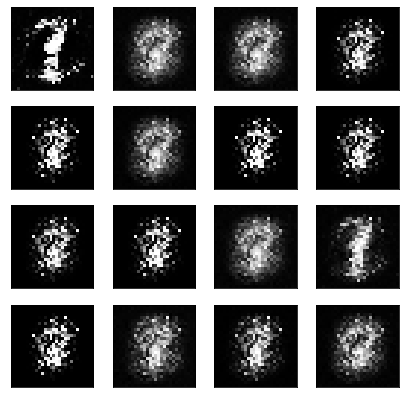

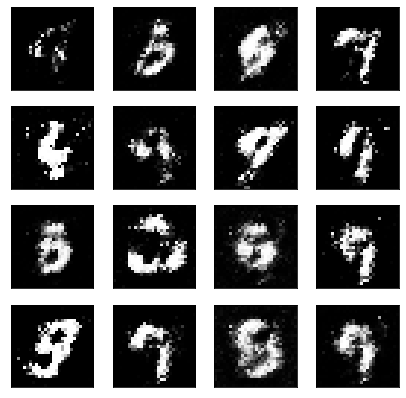

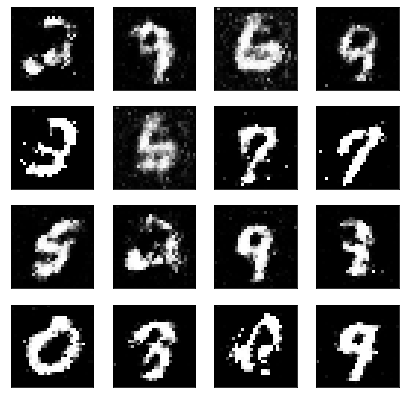

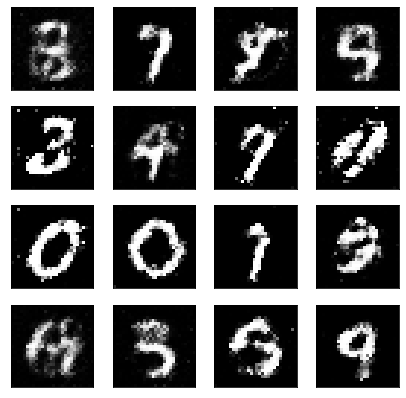

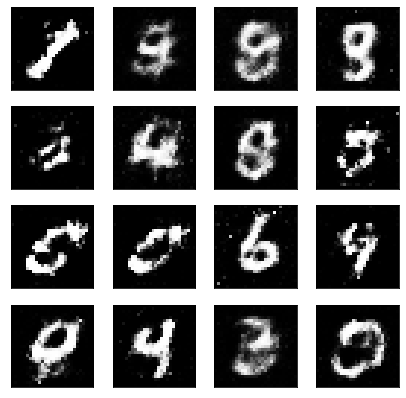

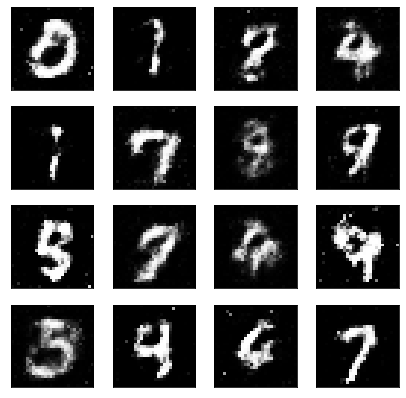

In [18]:
disc_losses, gen_losses = train(D, G, disc_opt, gen_opt, train_dl, batch_size)

# Plotting Losses
The discriminator and generator losses are plotted as a function of the number of epochs to observe the trend and allow for easier debugging.

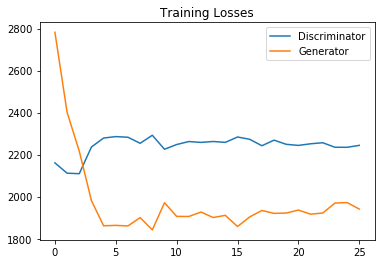

In [19]:
fig, ax = plt.subplots()
disc_losses = np.array(disc_losses)
gen_losses = np.array(gen_losses)
plt.plot(disc_losses, label='Discriminator')
plt.plot(gen_losses, label='Generator')
plt.title("Training Losses")
plt.legend()